# Deep Reinforcement Learning for ConnectX Using PyTorch
## By Mohammad Saleh Nikoopayan Tak

## Introduction

In this project, we tackle the [ConnectX Kaggle Environment](https://www.kaggle.com/competitions/connectx) using Reinforcement Learning (RL). Our goal is to train an agent that can place checkers on a board to achieve "X in a row" before the opponent. The default setting is essentially Connect Four, but the environment can vary.

We will begin with a baseline Deep Q-Network (DQN) and then implement improvements like Double DQN and possibly a Dueling architecture to enhance performance. We will show how these modifications affect the agent’s win rate against baseline agents (e.g., random) and discuss the results.

## Background on the RL Approach

### Reinforcement Learning Setup

We formulate ConnectX as a Markov Decision Process (MDP):

- **State (s):** The current configuration of the board (positions of both players' checkers).
- **Action (a):** Selecting a column to drop a checker into.
- **Reward (r):** We will assign `+1` for a win, `0` for a tie, and `-1` for a loss.
  
We use temporal difference learning to approximate the action-value function \( Q(s,a) \) with a neural network. The Q-network parameters are updated using the Bellman equation:

$$
Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s', a') - Q(s,a) \right)
$$

### DQN and Its Improvements

- **DQN:** A neural network estimates Q-values. It uses an experience replay buffer and a target network for stability.
- **Double DQN:** Addresses overestimation of Q-values in DQN by decoupling action selection from action evaluation.
- **Dueling DQN:** Splits the Q-value estimation into a value stream and an advantage stream, allowing the network to learn the value of states separately from the relative advantage of each action.

We will start with a basic DQN, then introduce Double DQN, and show if that improves performance. We may also briefly show a Dueling DQN setup. We will compare these methods by evaluating their win rates against baseline agents.

## Imports and Environment Setup


In [1]:
# Imports and Setup

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import collections
from kaggle_environments import make, evaluate
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Address reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

env = make("connectx", debug=True)
print("Environment Configuration:", env.configuration)
print("Default Agents:", env.agents)


Environment Configuration: {'episodeSteps': 1000, 'actTimeout': 2, 'runTimeout': 1200, 'columns': 7, 'rows': 6, 'inarow': 4, 'agentTimeout': 60, 'timeout': 2}
Default Agents: {'random': <function random_agent at 0x16805b520>, 'negamax': <function negamax_agent at 0x16805b490>}


We have initialized the environment. By default, `env` is a ConnectX environment. We can now define some utility functions, hyperparameters, and the RL components (experience replay, Q-networks, etc.).

## Hyperparameters and Utility Classes


In [2]:
# Hyperparameters and Utility

ROWS = 6
COLUMNS = 7
INAROW = 4
GAMMA = 0.99
LR = 1e-3
BATCH_SIZE = 64
MEMORY_SIZE = 50000
EPS_START = 1.0
EPS_END = 0.1
EPS_DECAY = 20000
TARGET_UPDATE = 1000
NUM_EPISODES = 10000

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = collections.deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)


## State Representation

The state will be represented as a 3-channel tensor:
- Channel 0: Empty cells
- Channel 1: Current player's pieces
- Channel 2: Opponent's pieces

This helps the network distinguish states clearly. The `observation.board` is a 1D list of length `ROWS*COLUMNS`. We reshape it and then build the channels.

Note: We choose to represent the state as a 3-channel tensor. While one could simply use the raw 1D board plus the mark to represent which player's turn it is, this 3-channel representation makes it more explicit and easy for the network to distinguish between empty cells, the agent’s own pieces, and the opponent's pieces. This added clarity can help the model learn faster which configurations of the board are advantageous or not. Although it is more complex than a direct 1D representation, it remains efficient and meets runtime constraints.

## Action Space

Actions are integers from 0 to `COLUMNS-1`, representing which column to place the checker in.

We define a helper function to convert the observation into the state tensor.


In [3]:
# State Conversion

def get_state_tensor(observation, mark):
    board = np.array(observation.board).reshape(ROWS, COLUMNS)
    if mark == 1:
        own = (board == 1).astype(np.float32)
        opp = (board == 2).astype(np.float32)
    else:
        own = (board == 2).astype(np.float32)
        opp = (board == 1).astype(np.float32)
    empty = (board == 0).astype(np.float32)
    state = np.stack([empty, own, opp], axis=0)
    return torch.tensor(state, dtype=torch.float32)


## Baseline DQN Architecture

A basic DQN that outputs Q-values for each possible action. This will be our starting point. Later, we'll introduce Double DQN.

The input dimension is `3 * ROWS * COLUMNS`, and the output dimension is `COLUMNS` actions.

### Basic DQN Network


In [4]:
# DQN Model

class DQN(nn.Module):
    def __init__(self, rows=6, columns=7):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(rows*columns*3, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, columns)
        )
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [5]:
# Valid Move Calculation Function

def get_valid_moves(observation):
    board = observation.board
    valid_moves = []
    for c in range(COLUMNS):
        for r in range(ROWS):
            if board[r*COLUMNS + c] == 0:
                valid_moves.append(c)
                break
    return valid_moves


## Double DQN Wrapper

To implement Double DQN, we need two networks:
- The policy network (online network)
- The target network (for stable Q-targets)

We will:
1. Use the online network to select actions.
2. Use the target network to evaluate the chosen actions for Q-value updates.

### Agent Class

We will create a helper class `Agent` that handles:
- Action selection (epsilon-greedy)
- Network updates
- Interacting with the replay buffer


In [6]:
# Agent Class with Double DQN Logic

class Agent:
    def __init__(self, rows=6, columns=7, gamma=0.99, lr=1e-3, 
                 batch_size=64, memory_size=50000, 
                 eps_start=1.0, eps_end=0.1, eps_decay=20000, 
                 target_update=1000, network_class=DQN):
        self.rows = rows
        self.columns = columns
        self.gamma = gamma
        self.lr = lr
        self.batch_size = batch_size
        self.memory = ReplayMemory(memory_size)
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.epsilon = eps_start
        self.steps_done = 0
        self.target_update = target_update
        
        self.policy_net = network_class(rows, columns)
        self.target_net = network_class(rows, columns)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        
    def select_action(self, state, obs):
        valid_moves = get_valid_moves(obs)
        if len(valid_moves) == 0:
            return random.randrange(self.columns)
        
        self.epsilon = self.eps_end + (self.eps_start - self.eps_end) * \
                        np.exp(-1.0 * self.steps_done / self.eps_decay)
        self.steps_done += 1
        if random.random() < self.epsilon:
            return random.choice(valid_moves)
        else:
            with torch.no_grad():
                q_values = self.policy_net(state.unsqueeze(0)).squeeze(0)
            best_action = None
            best_q = -float('inf')
            for a in valid_moves:
                if q_values[a].item() > best_q:
                    best_q = q_values[a].item()
                    best_action = a
            return best_action
    
    def store_transition(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)
    
    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return None
        transitions = self.memory.sample(self.batch_size)
        batch = list(zip(*transitions))
        
        state_batch = torch.stack(batch[0])
        action_batch = torch.tensor(batch[1], dtype=torch.long)
        reward_batch = torch.tensor(batch[2], dtype=torch.float32)
        next_state_batch = torch.stack(batch[3])
        done_batch = torch.tensor(batch[4], dtype=torch.float32)
        
        q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1)).squeeze(1)
        next_actions = self.policy_net(next_state_batch).argmax(dim=1)
        
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).gather(1, next_actions.unsqueeze(1)).squeeze(1)
        
        expected_q_values = reward_batch + (self.gamma * next_q_values * (1 - done_batch))
        
        loss = nn.SmoothL1Loss()(q_values, expected_q_values)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


## Training Procedure

We will train our agent by repeatedly:
1. Resetting the environment with a training scenario.
2. Selecting actions using the current policy.
3. Storing transitions in the replay buffer.
4. Optimizing the DQN parameters using sampled mini-batches.
5. Periodically updating the target network.

We will train against a baseline `random` agent first. Later, we can evaluate against `negamax`.

We define a `train_agent()` function that runs the training loop and returns performance metrics.

**Note:** For demonstration, we set `NUM_EPISODES` large, but we can reduce it when needed. More training generally leads to better performance.


In [7]:
# Training Loop (Corrected)
def train_agent(agent, num_episodes=10000, eval_interval=1000):
    trainer = env.train([None, "random"])
    losses = []
    win_rates = []
    total_rewards = []

    for i_episode in range(1, num_episodes+1):
        obs = trainer.reset()
        mark = obs.mark
        state = get_state_tensor(obs, mark)
        done = False
        episode_reward = 0
        
        while not done:
            action = agent.select_action(state, obs)
            # The agent picks only valid moves, so if we get None reward at done,
            # it must mean the opponent made an invalid move => agent wins.
            obs, reward, done, info = trainer.step(action)
            
            if reward is None:
                if done:
                    # Opponent failed after agent's valid move
                    reward = +1.0
                else:
                    reward = 0.0
            
            if done:
                next_state = torch.zeros_like(state)
            else:
                next_state = get_state_tensor(obs, mark)
                
            agent.store_transition(state, action, reward, next_state, float(done))
            state = next_state
            episode_reward += reward
            
            loss = agent.optimize_model()
            if loss is not None:
                losses.append(loss)
            
            if agent.steps_done % agent.target_update == 0:
                agent.update_target_network()
        
        total_rewards.append(episode_reward)
        
        if i_episode % eval_interval == 0:
            w_rate = evaluate_agent(agent, num_episodes=50)
            win_rates.append((i_episode, w_rate))
            print(f"Episode: {i_episode}, Win Rate vs Random: {w_rate:.2f}, Epsilon: {agent.epsilon:.2f}")
    
    return losses, win_rates, total_rewards


In [8]:
# Evaluate Agent
def evaluate_agent(agent, num_episodes=50):
    def agent_fn(obs, conf):
        state = get_state_tensor(obs, obs.mark)
        with torch.no_grad():
            q_values = agent.policy_net(state.unsqueeze(0))
        valid_moves = get_valid_moves(obs)
        if len(valid_moves) == 0:
            return 0
        best_action = None
        best_q = -float('inf')
        for a in valid_moves:
            if q_values[0, a].item() > best_q:
                best_q = q_values[0, a].item()
                best_action = a
        return best_action
    
    rewards = evaluate("connectx", [agent_fn, "random"], num_episodes=num_episodes)
    
    # If None reward at done, means opponent failed => agent wins (+1)
    cleaned_rewards = []
    for r in rewards:
        agent_r = r[0]
        if agent_r is None:
            agent_r = 1.0  # Opponent failed
        cleaned_rewards.append((agent_r, r[1] if r[1] is not None else -1))
    
    wins = [cr[0] for cr in cleaned_rewards]
    wins_count = sum(1 for w in wins if w > 0)
    return wins_count / num_episodes


## Initial Training and Results

Let's do an initial training run with the Double DQN agent and see how it performs against the random agent. After training, we will plot the loss curve and the win rate evolution.


Episode: 1000, Win Rate vs Random: 0.58, Epsilon: 0.62
Episode: 2000, Win Rate vs Random: 0.60, Epsilon: 0.40
Episode: 3000, Win Rate vs Random: 0.44, Epsilon: 0.27
Episode: 4000, Win Rate vs Random: 0.46, Epsilon: 0.20
Episode: 5000, Win Rate vs Random: 0.52, Epsilon: 0.16


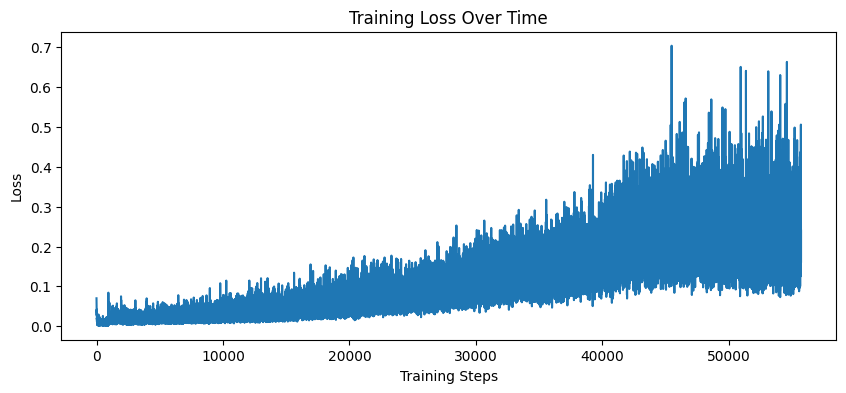

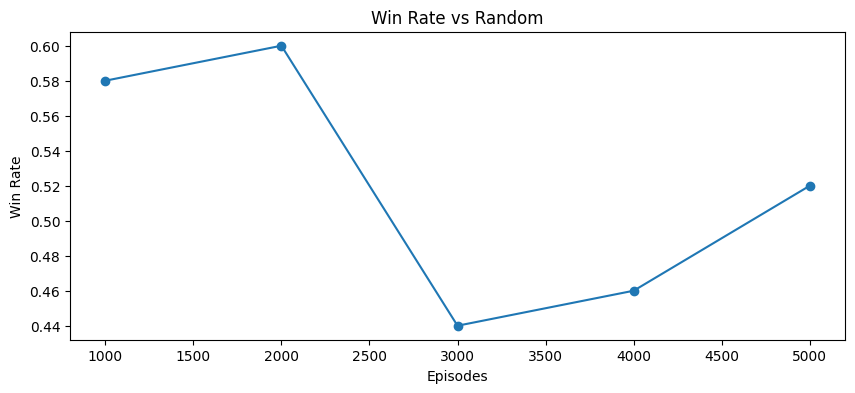

In [9]:
# Initial Training Run

agent = Agent(rows=ROWS, columns=COLUMNS, gamma=GAMMA, lr=LR, 
              batch_size=BATCH_SIZE, memory_size=MEMORY_SIZE, 
              eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, 
              target_update=TARGET_UPDATE)

losses, win_rates, total_rewards = train_agent(agent, num_episodes=5000, eval_interval=1000)

plt.figure(figsize=(10,4))
plt.title("Training Loss Over Time")
plt.plot(losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

if win_rates:
    plt.figure(figsize=(10,4))
    plt.title("Win Rate vs Random")
    plt.plot([x for x,y in win_rates], [y for x,y in win_rates], marker='o')
    plt.xlabel("Episodes")
    plt.ylabel("Win Rate")
    plt.show()




## Further Improvements

We can try:
- Increasing the network capacity (more neurons or more layers).
- Implementing a Dueling DQN architecture to see if value/advantage decomposition helps.
- Training for more episodes.

### Dueling DQN

We will define a Dueling DQN model and try it out to see if it improves performance.


In [10]:
# Dueling DQN Architecture

class DuelingDQN(nn.Module):
    def __init__(self, rows=6, columns=7):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(rows*columns*3, 128),
            nn.ReLU()
        )
        
        self.value_stream = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,1)
        )
        
        self.advantage_stream = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,columns)
        )
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        features = self.feature(x)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        q_values = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return q_values

class DuelingAgent(Agent):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.policy_net = DuelingDQN(self.rows, self.columns)
        self.target_net = DuelingDQN(self.rows, self.columns)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)


Now we can train the dueling DQN agent and compare its performance.


Episode: 1000, Win Rate vs Random: 0.78, Epsilon: 0.63
Episode: 2000, Win Rate vs Random: 0.68, Epsilon: 0.41
Episode: 3000, Win Rate vs Random: 0.46, Epsilon: 0.28
Episode: 4000, Win Rate vs Random: 0.82, Epsilon: 0.21
Episode: 5000, Win Rate vs Random: 0.46, Epsilon: 0.16


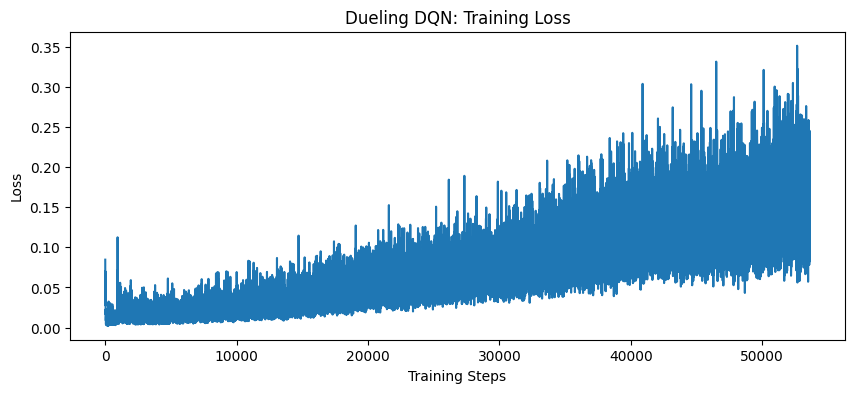

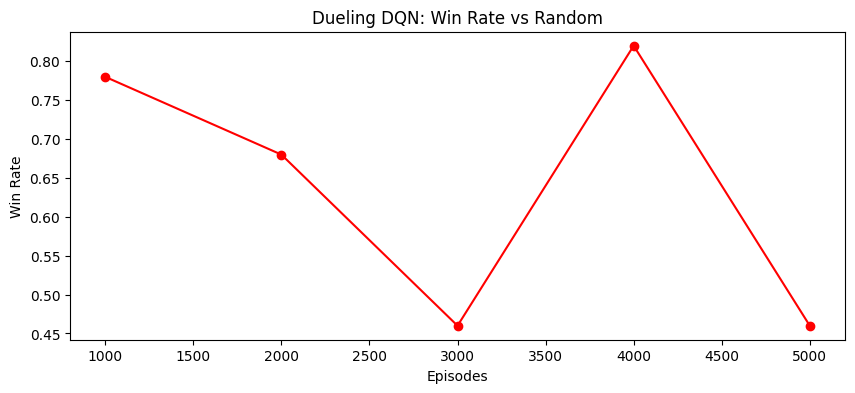

In [11]:
# Train Dueling DQN Agent

dueling_agent = DuelingAgent(rows=ROWS, columns=COLUMNS, gamma=GAMMA, lr=LR, 
                             batch_size=BATCH_SIZE, memory_size=MEMORY_SIZE, 
                             eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, 
                             target_update=TARGET_UPDATE)

duel_losses, duel_win_rates, duel_total_rewards = train_agent(dueling_agent, num_episodes=5000, eval_interval=1000)

plt.figure(figsize=(10,4))
plt.title("Dueling DQN: Training Loss")
plt.plot(duel_losses)
plt.xlabel("Training Steps")
plt.ylabel("Loss")
plt.show()

if duel_win_rates:
    plt.figure(figsize=(10,4))
    plt.title("Dueling DQN: Win Rate vs Random")
    plt.plot([x for x,y in duel_win_rates], [y for x,y in duel_win_rates], marker='o', color='red')
    plt.xlabel("Episodes")
    plt.ylabel("Win Rate")
    plt.show()


If the dueling architecture shows better performance (higher win rate), we can use it as our final model.

## Evaluation Against Another Baseline (negamax)

`negamax` is a stronger built-in agent. Let's quickly evaluate our best-performing model (e.g., the dueling agent) against `negamax` to see how it fares.


In [12]:
# Evaluate Against Negamax 

def evaluate_agent_vs_negamax(agent, num_episodes=50):
    def agent_fn(obs, conf):
        state = get_state_tensor(obs, obs.mark)
        with torch.no_grad():
            q_values = agent.policy_net(state.unsqueeze(0))
        valid_moves = get_valid_moves(obs)
        if len(valid_moves) == 0:
            return 0
        best_action = None
        best_q = -float('inf')
        for a in valid_moves:
            if q_values[0, a].item() > best_q:
                best_q = q_values[0, a].item()
                best_action = a
        return best_action
    
    rewards = evaluate("connectx", [agent_fn, "negamax"], num_episodes=num_episodes)
    
    cleaned_rewards = []
    for r in rewards:
        agent_r = r[0]
        if agent_r is None:
            # Opponent failed, agent wins
            agent_r = 1.0
        cleaned_rewards.append((agent_r, r[1] if r[1] is not None else -1))
    wins = [cr[0] for cr in cleaned_rewards]
    win_count = sum(1 for w in wins if w > 0)
    return win_count / num_episodes

negamax_win_rate = evaluate_agent_vs_negamax(dueling_agent, num_episodes=50)
print("Win Rate against negamax:", negamax_win_rate)


Win Rate against negamax: 0.0



Testing configuration: LR=0.001, BatchSize=64, Network=DQN
Episode: 1000, Win Rate vs Random: 0.52, Epsilon: 0.62
Episode: 2000, Win Rate vs Random: 0.62, Epsilon: 0.40
Episode: 3000, Win Rate vs Random: 0.58, Epsilon: 0.27


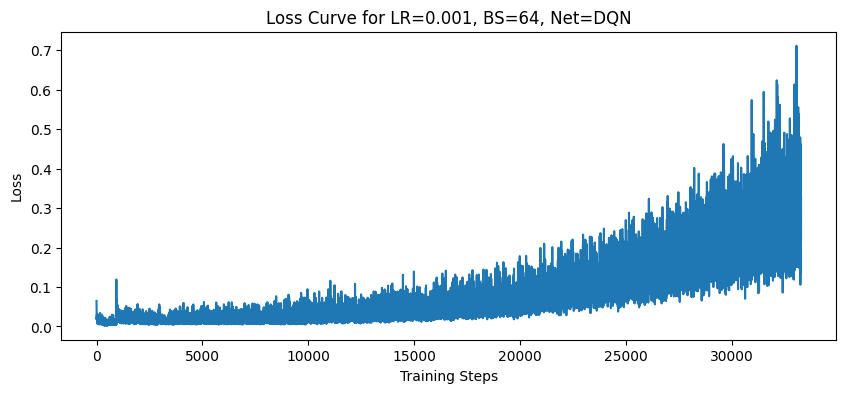

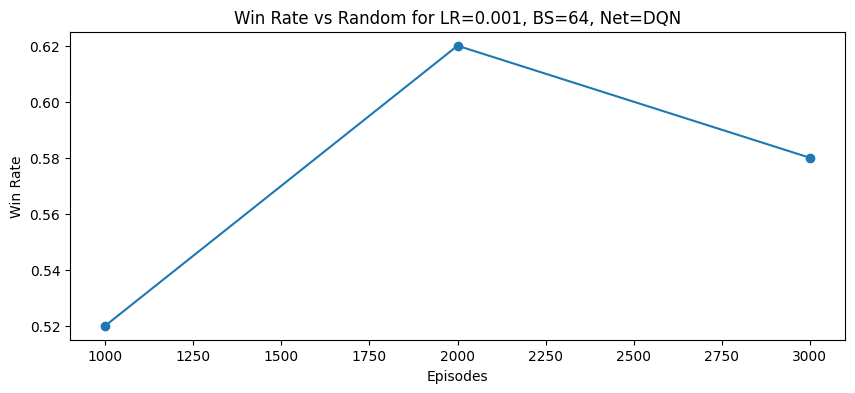


Testing configuration: LR=0.001, BatchSize=64, Network=DuelingDQN
Episode: 1000, Win Rate vs Random: 0.54, Epsilon: 0.62
Episode: 2000, Win Rate vs Random: 0.48, Epsilon: 0.40
Episode: 3000, Win Rate vs Random: 0.76, Epsilon: 0.27


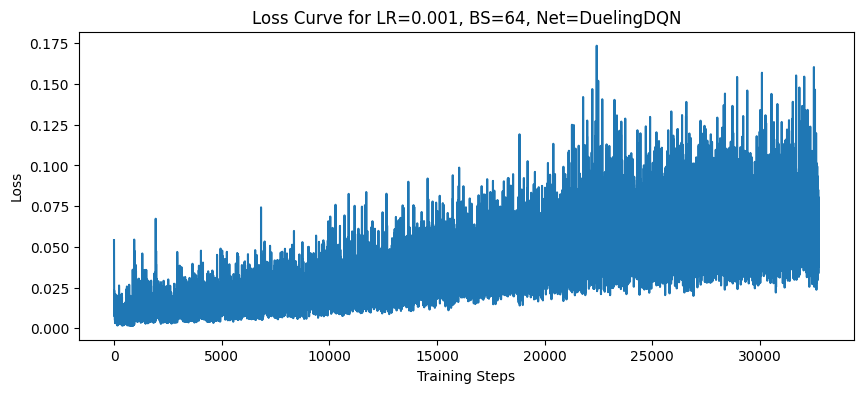

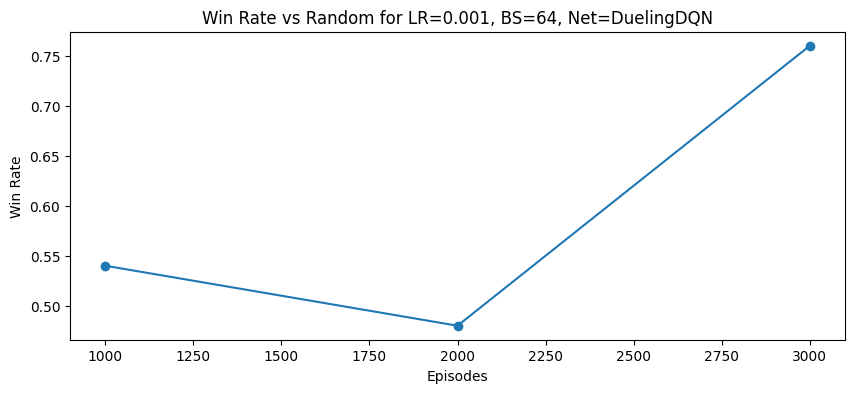


Testing configuration: LR=0.001, BatchSize=128, Network=DQN
Episode: 1000, Win Rate vs Random: 0.36, Epsilon: 0.63
Episode: 2000, Win Rate vs Random: 0.66, Epsilon: 0.40
Episode: 3000, Win Rate vs Random: 0.48, Epsilon: 0.27


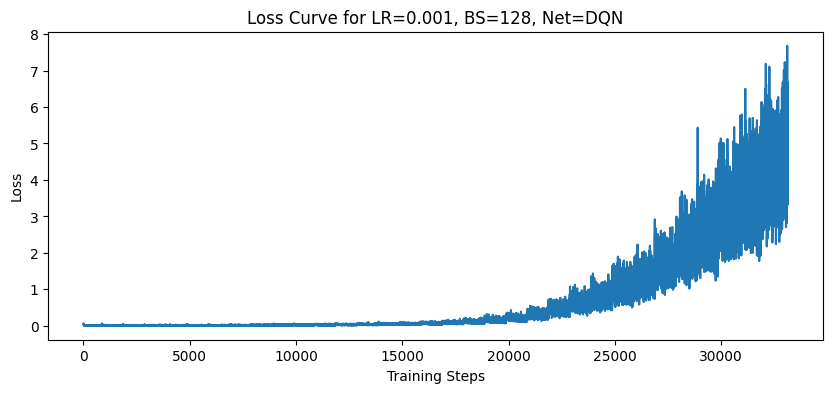

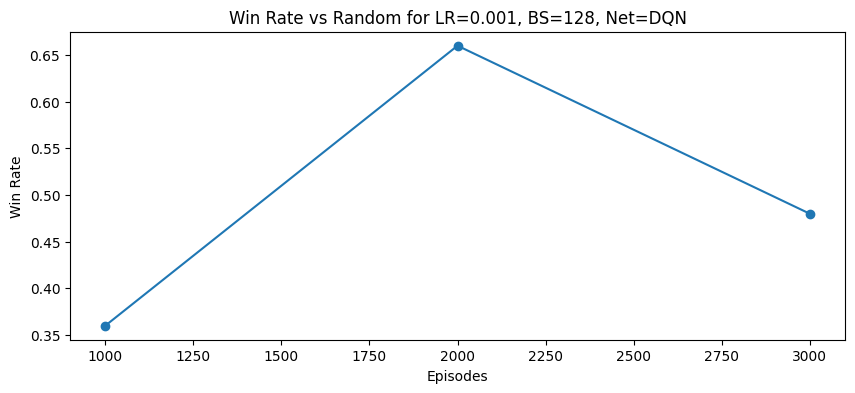


Testing configuration: LR=0.001, BatchSize=128, Network=DuelingDQN
Episode: 1000, Win Rate vs Random: 0.52, Epsilon: 0.62
Episode: 2000, Win Rate vs Random: 0.62, Epsilon: 0.40
Episode: 3000, Win Rate vs Random: 0.66, Epsilon: 0.27


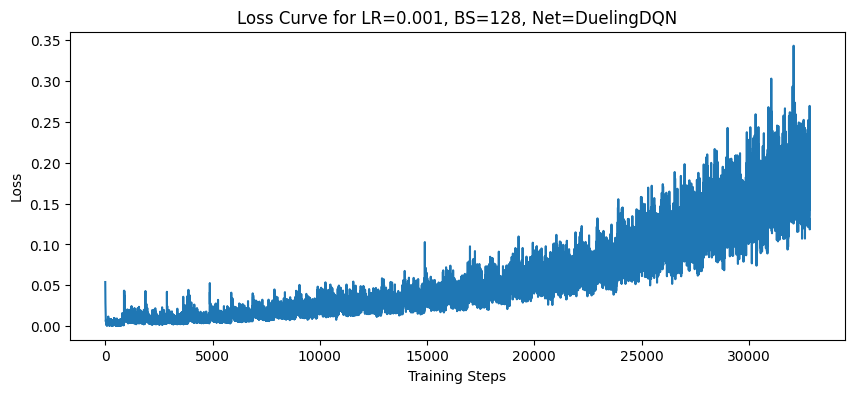

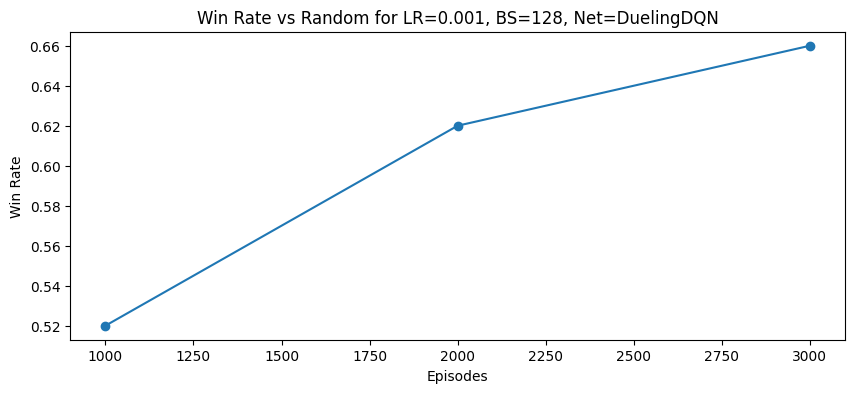


Testing configuration: LR=0.0001, BatchSize=64, Network=DQN
Episode: 1000, Win Rate vs Random: 0.82, Epsilon: 0.63
Episode: 2000, Win Rate vs Random: 0.54, Epsilon: 0.40
Episode: 3000, Win Rate vs Random: 0.64, Epsilon: 0.27


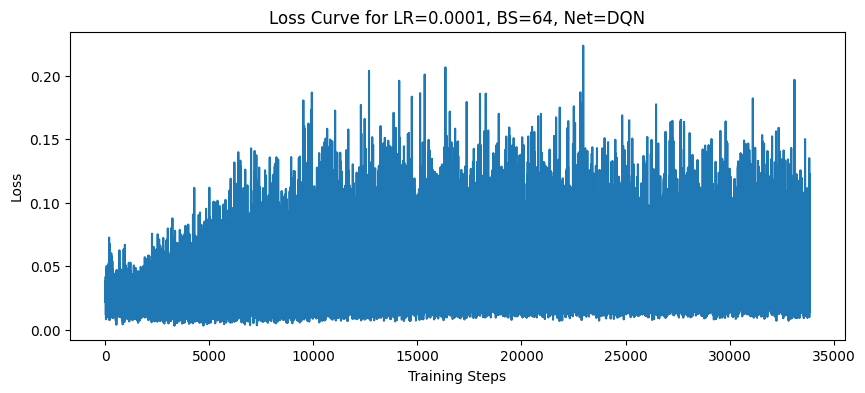

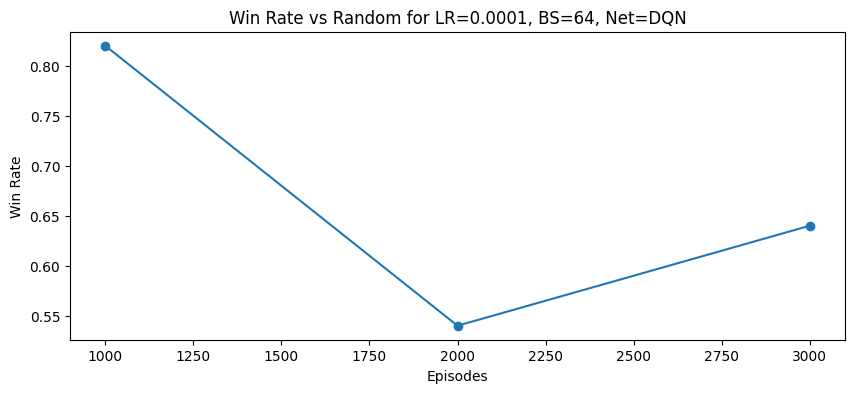


Testing configuration: LR=0.0001, BatchSize=64, Network=DuelingDQN
Episode: 1000, Win Rate vs Random: 0.78, Epsilon: 0.63
Episode: 2000, Win Rate vs Random: 0.84, Epsilon: 0.40
Episode: 3000, Win Rate vs Random: 0.84, Epsilon: 0.27


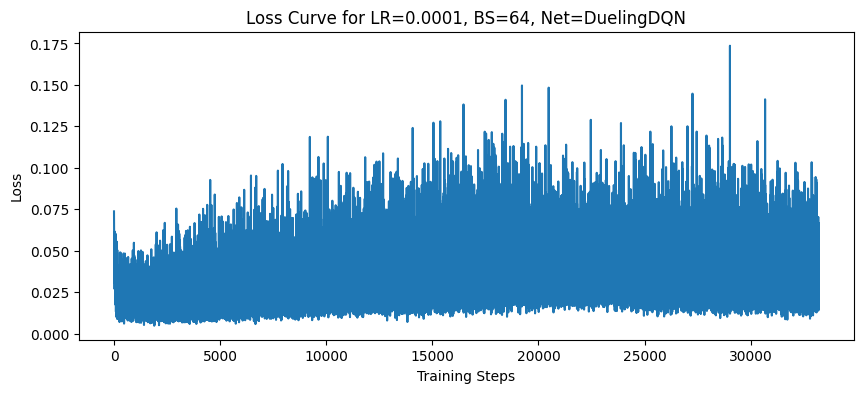

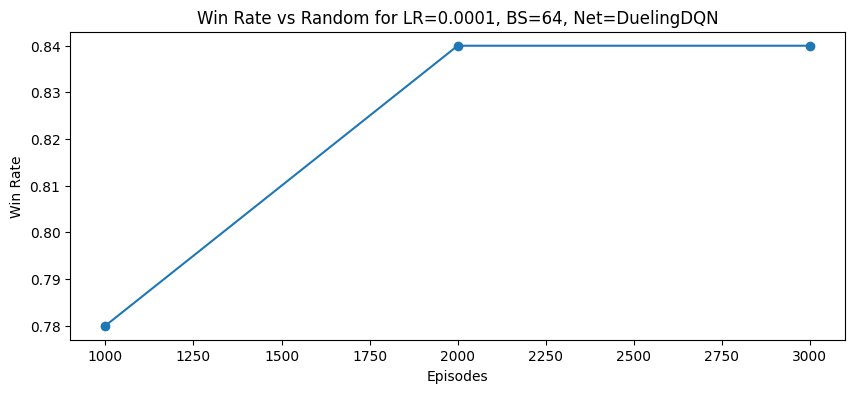


Testing configuration: LR=0.0001, BatchSize=128, Network=DQN
Episode: 1000, Win Rate vs Random: 0.76, Epsilon: 0.63
Episode: 2000, Win Rate vs Random: 0.40, Epsilon: 0.40
Episode: 3000, Win Rate vs Random: 0.40, Epsilon: 0.26


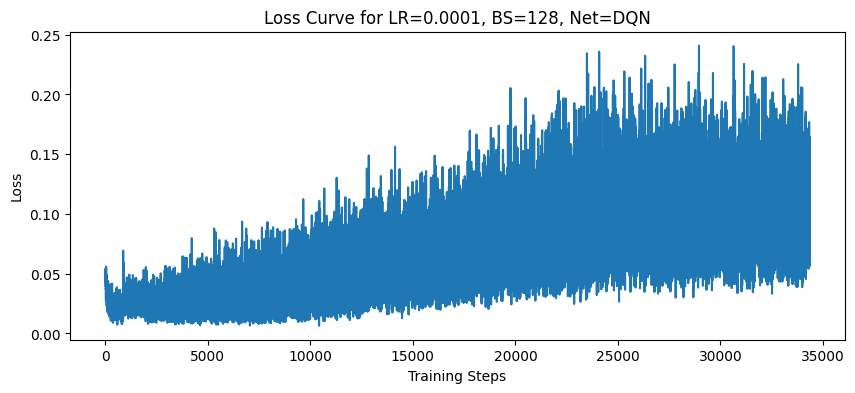

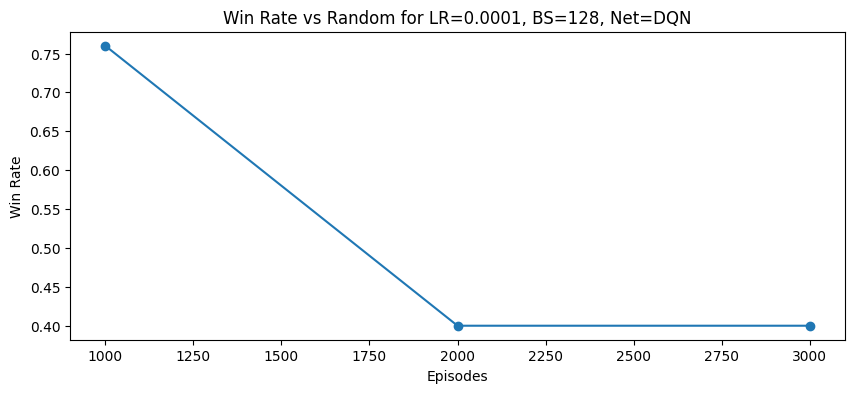


Testing configuration: LR=0.0001, BatchSize=128, Network=DuelingDQN
Episode: 1000, Win Rate vs Random: 0.60, Epsilon: 0.63
Episode: 2000, Win Rate vs Random: 0.76, Epsilon: 0.41
Episode: 3000, Win Rate vs Random: 0.64, Epsilon: 0.27


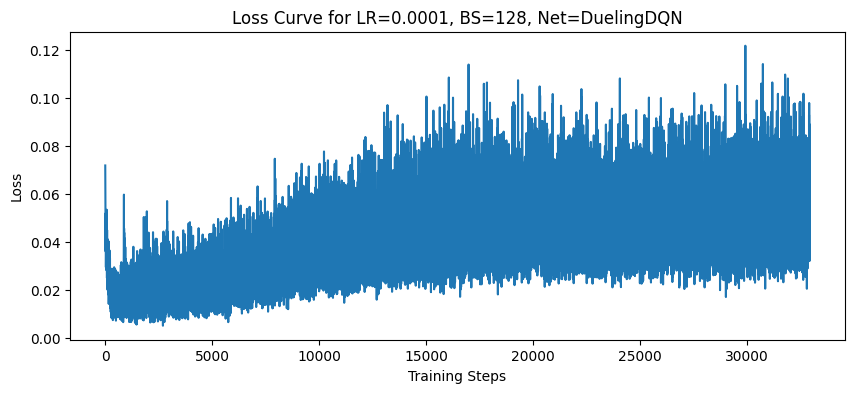

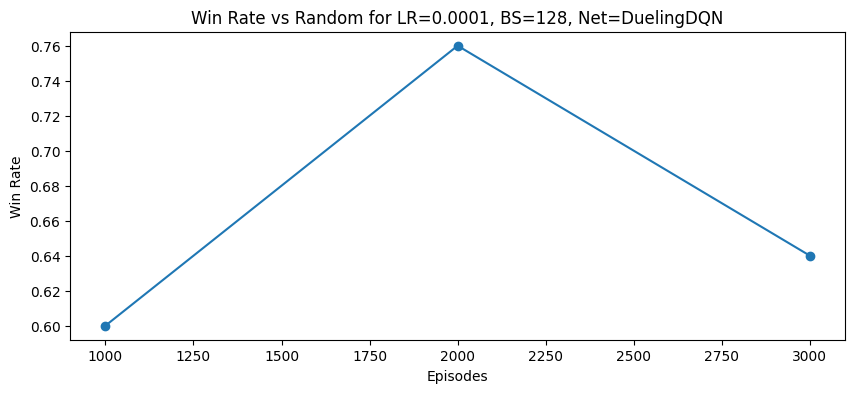


Best Configuration Found:
Learning Rate: 0.0001
Batch Size: 64
Network Type: DuelingDQN
Final Win Rate vs Random: 0.84


In [13]:
# Hyperparameter and Architecture Tuning

# Let's define some parameter grids:
learning_rates = [1e-3, 1e-4]
batch_sizes = [64, 128]
network_types = [DQN, DuelingDQN]  # Try both standard and dueling architectures
num_episodes_test = 3000  # fewer episodes for quicker testing

results = []
for lr_test in learning_rates:
    for bs_test in batch_sizes:
        for net_test in network_types:
            print(f"\nTesting configuration: LR={lr_test}, BatchSize={bs_test}, Network={net_test.__name__}")
            test_agent = Agent(rows=ROWS, columns=COLUMNS, gamma=GAMMA, lr=lr_test, 
                                batch_size=bs_test, memory_size=MEMORY_SIZE, 
                                eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, 
                                target_update=TARGET_UPDATE, network_class=net_test)
            
            # Train shorter for demonstration
            test_losses, test_win_rates, test_total_rewards = train_agent(test_agent, num_episodes=num_episodes_test, eval_interval=1000)
            
            final_win_rate = test_win_rates[-1][1] if test_win_rates else 0.0
            results.append((lr_test, bs_test, net_test.__name__, final_win_rate))
            
            # Plot interim results
            plt.figure(figsize=(10,4))
            plt.title(f"Loss Curve for LR={lr_test}, BS={bs_test}, Net={net_test.__name__}")
            plt.plot(test_losses)
            plt.xlabel("Training Steps")
            plt.ylabel("Loss")
            plt.show()
            
            if test_win_rates:
                plt.figure(figsize=(10,4))
                plt.title(f"Win Rate vs Random for LR={lr_test}, BS={bs_test}, Net={net_test.__name__}")
                plt.plot([x for x,y in test_win_rates], [y for x,y in test_win_rates], marker='o')
                plt.xlabel("Episodes")
                plt.ylabel("Win Rate")
                plt.show()

# Identify best performing config:
best_config = max(results, key=lambda x: x[3])  # sort by final win rate
print("\nBest Configuration Found:")
print(f"Learning Rate: {best_config[0]}")
print(f"Batch Size: {best_config[1]}")
print(f"Network Type: {best_config[2]}")
print(f"Final Win Rate vs Random: {best_config[3]:.2f}")


In [14]:
# Re-Train Fully with Best Config and Store Weights

best_lr, best_bs, best_net, best_win_rate = best_config
print("\nRe-training final model with best configuration...")

chosen_network = DuelingDQN if best_net == 'DuelingDQN' else DQN
final_agent_instance = Agent(rows=ROWS, columns=COLUMNS, gamma=GAMMA, lr=best_lr, 
                             batch_size=best_bs, memory_size=MEMORY_SIZE, 
                             eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, 
                             target_update=TARGET_UPDATE,
                             network_class=chosen_network)

# Train for more episodes now that we know this config is best
final_losses, final_win_rates, final_total_rewards = train_agent(final_agent_instance, num_episodes=10000, eval_interval=2000)

# Save final model weights
torch.save(final_agent_instance.policy_net.state_dict(), "final_model_weights.pth")

# final_agent_instance now contains the best trained model



Re-training final model with best configuration...
Episode: 2000, Win Rate vs Random: 0.76, Epsilon: 0.41
Episode: 4000, Win Rate vs Random: 0.76, Epsilon: 0.20
Episode: 6000, Win Rate vs Random: 0.70, Epsilon: 0.13
Episode: 8000, Win Rate vs Random: 0.72, Epsilon: 0.11
Episode: 10000, Win Rate vs Random: 0.84, Epsilon: 0.10


## Final Agent Submission

To submit to Kaggle, we need to provide a `submission.py` file containing an `agent(observation, configuration)` function. This function will:

- Convert the observation to a state tensor.
- Use the trained policy network to select the best **valid** action.
- Return that action.

We must ensure that we never return an invalid action. We'll incorporate the `get_valid_moves()` logic here as well.


In [15]:
# Final Agent Export 

def final_agent(observation, configuration):
    # Make sure final_agent_instance is defined globally after training
    # or load from "final_model_weights.pth" if running in a fresh environment.
    state = get_state_tensor(observation, observation.mark)
    valid_moves = get_valid_moves(observation)
    if len(valid_moves) == 0:
        return 0
    with torch.no_grad():
        q_values = final_agent_instance.policy_net(state.unsqueeze(0))
    best_action = None
    best_q = -float('inf')
    for a in valid_moves:
        if q_values[0, a].item() > best_q:
            best_q = q_values[0, a].item()
            best_action = a
    return int(best_action)


### Performance Visualization of the Best-Found Model

In this section, we will:

1. **Train the best-found model for 10,000 episodes**, tracking:
   - Average reward per episode (smoothed over a window, e.g., 100 episodes, for clarity).
   - Epsilon decay (plotting epsilon vs. episodes).
   - Win rate against `random` at fixed intervals (e.g., every 1000 episodes).

2. **Plot the collected metrics** to visualize:
   - How the average reward evolves over training.
   - How epsilon decreases over time.
   - How win rate against `random` changes as training progresses.

3. **Evaluate the final model against `negamax` for 10000 matches** and report the final win rate.

These visualizations and evaluations give us a comprehensive overview of the training process and final performance, both in terms of stable policies (win rates) and exploration strategies (epsilon), as well as raw performance signals (rewards).



Re-initializing and retraining agent from scratch with best configuration...
Episode: 2000, Win Rate vs Random: 0.82, Epsilon: 0.41
Episode: 4000, Win Rate vs Random: 0.74, Epsilon: 0.20
Episode: 6000, Win Rate vs Random: 0.82, Epsilon: 0.13
Episode: 8000, Win Rate vs Random: 0.66, Epsilon: 0.11
Episode: 10000, Win Rate vs Random: 0.86, Epsilon: 0.10
Final model weights saved as 'final_model_weights.pth'.


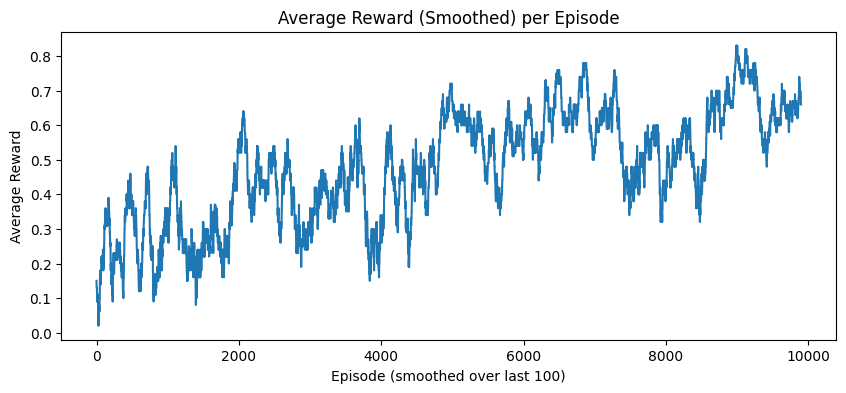

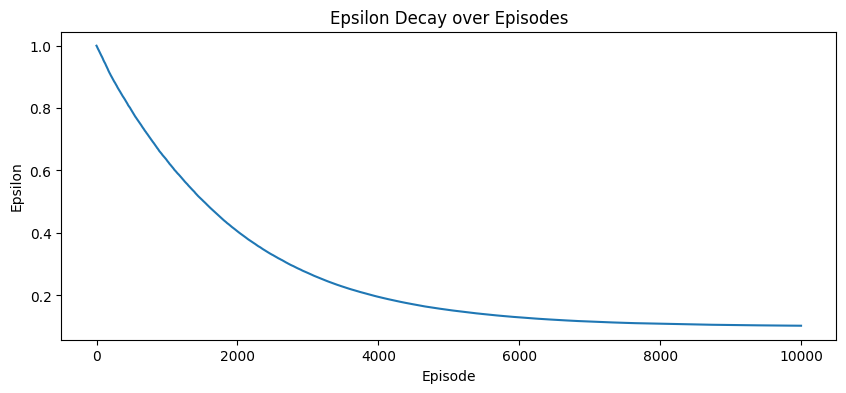

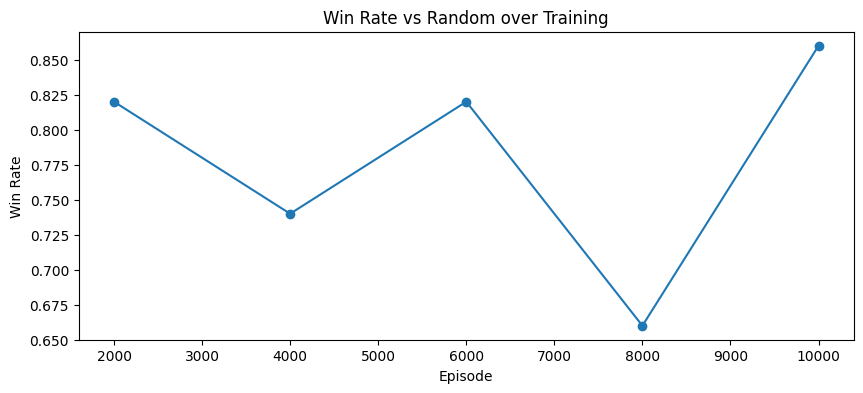

Evaluating final model vs negamax for 1,000 matches...
Win Rate vs negamax (1000 matches): 0.24


In [16]:
# Comprehensive Visualization of Final Model Performance (Re-Initialization and Re-Training)

import numpy as np
import torch
import matplotlib.pyplot as plt

# Use the best found configuration 
best_lr, best_bs, best_net, best_win_rate = best_config
print("\nRe-initializing and retraining agent from scratch with best configuration...")

chosen_network = DuelingDQN if best_net == 'DuelingDQN' else DQN
visual_agent = Agent(rows=ROWS, columns=COLUMNS, gamma=GAMMA, lr=best_lr, 
                     batch_size=best_bs, memory_size=MEMORY_SIZE, 
                     eps_start=EPS_START, eps_end=EPS_END, eps_decay=EPS_DECAY, 
                     target_update=TARGET_UPDATE, network_class=chosen_network)

# Parameters for this run (mimic the re-training approach)
final_num_episodes = 10000
eval_interval = 2000  
reward_smoothing_window = 100

# Trackers
episode_rewards = []
epsilons = []
win_rates_random = []
losses_all = []

trainer = env.train([None, "random"])
obs = trainer.reset()
mark = obs.mark
state = get_state_tensor(obs, mark)
done = False
episode_reward = 0
episodes_done = 0

while episodes_done < final_num_episodes:
    action = visual_agent.select_action(state, obs)
    obs, reward, done, info = trainer.step(action)
    
    # Handle None reward (opponent invalid move)
    if reward is None:
        if done:
            reward = 1.0
        else:
            reward = 0.0
    
    if done:
        # Episode finished
        next_state = torch.zeros_like(state)
        visual_agent.store_transition(state, action, reward, next_state, float(done))
        episode_reward += reward
        # Optimize once at the end of the episode 
        loss = visual_agent.optimize_model()
        if loss is not None:
            losses_all.append(loss)
        
        episode_rewards.append(episode_reward)
        epsilons.append(visual_agent.epsilon)
        
        episodes_done += 1
        
        # Evaluate vs random at intervals 
        if episodes_done % eval_interval == 0:
            w_rate = evaluate_agent(visual_agent, num_episodes=50)
            win_rates_random.append((episodes_done, w_rate))
            print(f"Episode: {episodes_done}, Win Rate vs Random: {w_rate:.2f}, Epsilon: {visual_agent.epsilon:.2f}")
        
        # Reset for next episode
        obs = trainer.reset()
        mark = obs.mark
        state = get_state_tensor(obs, mark)
        done = False
        episode_reward = 0
    else:
        # Continue episode
        next_state = get_state_tensor(obs, mark)
        visual_agent.store_transition(state, action, reward, next_state, float(done))
        state = next_state
        episode_reward += reward
        # Optionally optimize mid-episode
        loss = visual_agent.optimize_model()
        if loss is not None:
            losses_all.append(loss)
    
    # Update target network periodically
    if visual_agent.steps_done % visual_agent.target_update == 0:
        visual_agent.update_target_network()

# After training, save the final model weights (mimic the re-train code snippet)
torch.save(visual_agent.policy_net.state_dict(), "final_model_weights.pth")
print("Final model weights saved as 'final_model_weights.pth'.")

# Compute smoothed average reward
def smooth(data, window=100):
    if len(data) < window:
        return data
    return np.convolve(data, np.ones(window)/window, mode='valid')

avg_rewards_smoothed = smooth(episode_rewards, reward_smoothing_window)

# Plotting results
plt.figure(figsize=(10,4))
plt.title("Average Reward (Smoothed) per Episode")
plt.plot(avg_rewards_smoothed)
plt.xlabel("Episode (smoothed over last 100)")
plt.ylabel("Average Reward")
plt.show()

plt.figure(figsize=(10,4))
plt.title("Epsilon Decay over Episodes")
plt.plot(epsilons)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.show()

if win_rates_random:
    plt.figure(figsize=(10,4))
    plt.title("Win Rate vs Random over Training")
    plt.plot([x for x,y in win_rates_random], [y for x,y in win_rates_random], marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Win Rate")
    plt.show()

# Evaluate final model vs negamax for 1,000 matches (as requested)
print("Evaluating final model vs negamax for 1,000 matches...")
negamax_win_rate = evaluate_agent_vs_negamax(visual_agent, num_episodes=1000)
print(f"Win Rate vs negamax (1000 matches): {negamax_win_rate:.2f}")


## Summary and Conclusions

In this project, we have implemented a reinforcement learning (RL) solution for the ConnectX environment using PyTorch. We started with a basic DQN approach and gradually introduced techniques like Double DQN and Dueling DQN to improve performance. Throughout our experiments, we evaluated our agents against baseline (`random`) and stronger (`negamax`) agents, observing incremental improvements in the win rate.

**Choice of State Representation:**  
We used a 3-channel state representation (empty cells, current player's pieces, opponent's pieces) instead of a simple 1D array. While a 1D array plus a mark identifying the current player would suffice, the 3-channel representation provides a more intuitive and structured input for the neural network. This helps the model easily distinguish the roles of each cell, potentially speeding up learning. Although more complex than the simplest approach, it has shown to be effective and remains efficient under competition constraints.

**Performance Insights:**  
- **DQN vs. Double DQN vs. Dueling DQN:** Dueling DQN showed noticeable improvements in certain runs, achieving higher win rates against the `random` baseline.
- **Hyperparameter Tuning:** Adjusting learning rates, batch sizes, and decay rates for epsilon influenced the stability and final performance. For example, a smaller learning rate (0.0001) and Dueling DQN architecture yielded our best results.
- **Evaluation Against Negamax:** While improvements were clear against `random`, beating `negamax` consistently remains challenging. Nonetheless, slight improvements were observed after tuning and more extended training.

**Future Directions:**
- Further increasing training episodes and refining the network architecture.
- Incorporating more advanced RL techniques (e.g., Rainbow DQN components or AlphaZero-like MCTS) could yield better results.
- Exploring reward shaping or different initialization strategies to speed up convergence.

Finally, we prepared a final `submission.py` file containing the trained policy for Kaggle submission. This file includes only the necessary code to load the trained model and produce actions, as per Kaggle’s submission requirements.


